# 1 综述
本章节集中讨论机器学习中要解决的第二个现实问题：分类，主要包含以下几个形式：
1. 二分类：样本有且仅有互斥的两个类别，单一样本仅从属于其中一个类列；比如，识别一个信贷用户是否是欺诈用户。
2. 多分类：样本有互斥的多个类别，单一样本仅从属于其中一个类列；比如，识别一个水果是苹果、梨及香蕉等。
3. 多标签分类：样本有多个类别，单一样本属于其中一个或多个类列；比如，一篇新闻从属的标签：新闻、军事及国内等。
4. 多输出分类（**尚未能清晰理解**）：多个多分类或多标签分类组合输出的分类，网络至少会分支两次（有时候会更多），从而在网络末端创建出多组全连接头，然后你的网络的每个头都会预测一组类别标签，使其有可能学习到不相交的标签组合。比如一个网络同时预测服饰的款式类型和颜色类型。

案例基于美国高中生和人口调查局职员手写的 **7w** 张数字图片（28\*28）[MNIST](https://www.openml.org/d/554)数据集进行演练：

(-0.5, 27.5, 27.5, -0.5)

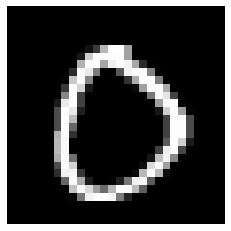

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

def GetData(name,dtype):
    X,y = fetch_openml(name,version=1,return_X_y=True,as_frame=False)
    data = np.hstack((X,y[:,None].astype(dtype)))
    np.random.seed(11)
    np.random.shuffle(data) # 乱序排列数据，避免数据顺序对后续分析和算法效果的影响
    X = data[:,:data.shape[1]-1]
    y = data[:,-1]
    return X,y

X,y = GetData('mnist_784',int)

plt.imshow(X[0].reshape(28,28),
           cmap = 'gray', # 颜色图谱
           interpolation="nearest") # 插值方法
plt.axis("off") # 去除坐标轴

# 2 二分类
稍作变换，将原始的y从0~9的标签转换为识别 **5** & **非5** 的二分类问题，然后我们层级渐进的进行二分类建模，梳理如下：
1. 直接建模：展示建模流程，梳理分类模型评价指标。
2. 叠加数据预处理：评估数据预处理的重要性。
3. 叠加交叉验证调参：评估参数的重要性。
4. 更换非线性模型

## 2.1 SGD分类模型
- 标签生成：

In [2]:
y_bin = (y == 5) + 0

- 切分数据：

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y_bin,test_size=0.3,random_state=7)

- 模型训练：

In [4]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=7) # 因为随机梯度下降，设定随机种子
sgd.fit(x_train,y_train)

SGDClassifier(random_state=7)

- 模型预测：

In [5]:
# 预测原始值
sgd.decision_function(x_train)

array([  7674.85138357,  -3376.18132092, -12791.18186363, ...,
       -12055.7902551 , -10187.90188782,   1243.89791941])

In [6]:
# 预测分类
sgd.predict(x_train)

array([1, 0, 0, ..., 0, 0, 1])

In [7]:
y_train_pred = sgd.predict(x_train)

- 模型评估：

In [8]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score

def BinEvaluate(y,y_pred):
    print('目标浓度：')
    print(Series(y).value_counts()/len(y))
    print('\n混淆矩阵：')
    print(confusion_matrix(y,y_pred)) # 行：y，列：y-pred
    print('准确率：%s' % (precision_score(y,y_pred))) # 预测某分类中 *% 的可能性是正确的
    print('召回率：%s' % (recall_score(y,y_pred))) # 实际某分类中 *% 的真值被识别
    print('F1 值：%s' % (f1_score(y,y_pred))) #  高 F1 值，需要召回率和准确率同时高
    print('ROC：%s' % (roc_auc_score(y,y_pred)))

BinEvaluate(y_train,y_train_pred)

目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44235   369]
 [ 1440  2956]]
准确率：0.8890225563909775
召回率：0.6724294813466788
F1 值：0.7657039243621293
ROC：0.8320783403504983


从评价指标可以看出，召回率不尽如人意，所以评估分类模型时，**不建议使用准确率作为评价指标**，因为当样本比严重失衡时，将全部结果预测为占绝对多数的单一类别时，准确率也极高，然而那样的模型是没有实际意义的。

## 2.2 叠加数据预处理
- 归一化：

In [9]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x_train_new = mm.fit_transform(x_train)
x_test_new = mm.transform(x_test)# 必须使用训练集的转换标准转换测试集

- 模型的训练 & 评估：

In [10]:
# 训练
sgd = SGDClassifier(random_state=7)
sgd.fit(x_train_new,y_train)
# 评估
BinEvaluate(y_train,sgd.predict(x_train_new))

目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44432   172]
 [  990  3406]]
准确率：0.9519284516489659
召回率：0.7747952684258417
F1 值：0.854276398294457
ROC：0.8854695560136562


经过归一化后的数据建模效果得到了较大的提升，其中召回率提升明显。
## 2.3 叠加交叉验证调参
因为上文中表达了准确率的缺陷，综合准确率和召回率的F1值对交叉验证进行评估。
### 2.3.1 基于 *2.1* 叠加5折交叉验证

In [11]:
from sklearn.model_selection import cross_val_score
sgd = SGDClassifier(random_state=7)
cross_val_score(sgd,x_train,y_train,cv=5,scoring='f1')

array([0.74821514, 0.8117506 , 0.78548695, 0.81288724, 0.76979167])

### 2.3.2 基于 *2.2* 叠加5折交叉验证

In [12]:
sgd = SGDClassifier(random_state=7)
cross_val_score(sgd,x_train_new,y_train,cv=5,scoring='f1')

array([0.86305539, 0.84530064, 0.8283208 , 0.85859729, 0.84741641])

通过交叉验证比较，我们可以发现归一化对模型的提升是很显著的、稳定的，所以我们使用归一化后建立的模型进行下一步分析。
### 2.3.3 调参
我们对**随机种子**的数值进行下评估：

In [13]:
for i in range(10):
    sgd = SGDClassifier(random_state=i)
    f1 = cross_val_score(sgd,x_train_new,y_train,cv=5,scoring='f1')
    print('随机种子：%s,平均F1值：%s。' % (i,np.mean(f1)))

随机种子：0,平均F1值：0.830751747067214。
随机种子：1,平均F1值：0.8558710462462388。
随机种子：2,平均F1值：0.8311852923297757。
随机种子：3,平均F1值：0.8368578007938068。
随机种子：4,平均F1值：0.8462409496237802。
随机种子：5,平均F1值：0.8474147274409297。
随机种子：6,平均F1值：0.8187530528265754。
随机种子：7,平均F1值：0.8485381058166311。
随机种子：8,平均F1值：0.8438734396861479。
随机种子：9,平均F1值：0.8235415881732104。


选定数字 **1** 作为随机种子，建立模型并评估在测试集上的效果。

In [22]:
from sklearn.model_selection import cross_val_predict
sgd = SGDClassifier(random_state=1)
sgd.fit(x_train_new,y_train)
print('训练集：')
pred_train = sgd.predict(x_train_new)
BinEvaluate(y_train,pred_train)
print('\n测试集：')
pred_test = sgd.predict(x_test_new)
BinEvaluate(y_test,pred_test)

训练集：
目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44152   452]
 [  658  3738]]
准确率：0.8921241050119332
召回率：0.8503184713375797
F1 值：0.8707197763801537
ROC：0.9200924255172339

测试集：
目标浓度：
0    0.908714
1    0.091286
dtype: float64

混淆矩阵：
[[18875   208]
 [  305  1612]]
准确率：0.8857142857142857
召回率：0.8408972352634324
F1 值：0.8627241102488628
ROC：0.914998740777972


预测效果还是令人满意的，衰变也不是很严重。
## 2.4 随机森林建模
我们知道图像识别应该不太适用于SGD线性分类，所以我们准备将模型换成随机森林来比较下:

训练集：
目标浓度：
0    0.910286
1    0.089714
dtype: float64

混淆矩阵：
[[44594    10]
 [  444  3952]]
准确率：0.9974760222110045
召回率：0.8989990900818926
F1 值：0.9456807848767648
ROC：0.9493874474712216

测试集：
目标浓度：
0    0.908714
1    0.091286
dtype: float64

混淆矩阵：
[[19058    25]
 [  293  1624]]
准确率：0.9848392965433597
召回率：0.8471570161711007
F1 值：0.9108244531688167
ROC：0.9229234748098599


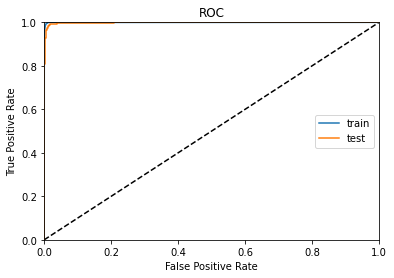

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

def PltRoc(y_train,y_test,pred_train,pred_test):
    fpr_train,tpr_train,thresholds_train = roc_curve(y_train,pred_train)
    fpr_test,tpr_test,thresholds_test = roc_curve(y_test,pred_test)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train,tpr_train,label='train')
    plt.plot(fpr_test,tpr_test,label='test')
    plt.legend(loc="right")
    plt.title('ROC')
    plt.show()

rf = RandomForestClassifier(n_estimators=200,
                            criterion='entropy', # gini/entropy
                            max_depth=None,
                            min_samples_split=50,
                            max_features='auto',
                            n_jobs=-1,
                            random_state=7)

rf.fit(x_train_new,y_train)

print('训练集：')
pred_train = rf.predict(x_train_new)
BinEvaluate(y_train,pred_train)

print('\n测试集：')
pred_test = rf.predict(x_test_new)
BinEvaluate(y_test,pred_test)

pred_proba_train = rf.predict_proba(x_train_new)[:,1]
pred_proba_test = rf.predict_proba(x_test_new)[:,1]

PltRoc(y_train,y_test,pred_proba_train,pred_proba_test)

识别精度有了显著的提升，随机森林中又有多个参数可以调参，如果叠加交叉验证进行调参的话说不定会有更好的结果。不过，由于随机森林参数多，参数间存在相互影响，所以后面我们会介绍一种超参数搜索的方法，此处就不展开了。
# 3 多分类
下面我们来分析如何处理多分类问题，经过刚刚对二分类问题探索，我们能想到的一种简单的方法就是将多类问题拆解成多个二分类问题，这样子，
- 一对所有（OvA）策略
将每一次的一个类作为正例，其余作为反例，总共训练N个分类器。测试的时候若仅有一个分类器预测为正的类别则对应的类别标记作为最终分类结果，若有多个分类器预测为正类，则选择置信度最大的类别作为最终分类结果。
- 一对一OvO 策略
给定数据集D这里有N个类别，这种情况下就是将这些类别两两配对，从而产生N(N−1)2个二分类任务，在测试的时候把样本交给这些分类器，然后进行投票。

# 多标签分类
到现在为止，我们看到的模型与数据都是将一条数据分类为一个类别。在某些情况下，我们可能需要分类器为每条数据输出多个类别。例如，假设有一个人脸识别分类器，如果它在同一张图片上认出了多张人脸的话，它应该输出什么呢？显然，它应该为每个它认出的人脸打上一个标志。


面临的问题：
图片的标签数目不是固定的，有的有一个标签，有的有两个标签，但标签的种类总数是固定的，比如为5类。

解决该问题：
采用了标签补齐的方法，即缺失的标签全部使用0标记，这意味着，不再使用one-hot编码。例如：标签为：-1,1,1,-1,1 ;-1表示该类标签没有，1表示该类标签存在，则这张图片的标签编码为：

0 0 0 0 0
0 1 0 0 0
0 0 1 0 0
0 0 0 0 0
0 0 0 0 1

2.如何衡量损失？

计算出一张图片各个标签的损失，然后取平均值。

3.如何计算精度

计算出一张图片各个标签的精度，然后取平均值。

该处理方法的本质：把一个多标签问题，转化为了在每个标签上的二分类问题。

# 多输出分类